In [101]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')


X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [102]:

train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Aggregating data

In [103]:
all_observed_X = pd.concat([X_train_observed_a,X_train_observed_b,X_train_observed_c])
all_estimated_X = pd.concat([X_train_estimated_a,X_train_estimated_b,X_train_estimated_c])

X_test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])
X_train = pd.concat([all_observed_X,all_estimated_X])

y_train = pd.concat([train_a,train_b,train_c])

X_train['time'] = X_train['date_forecast'].dt.floor('H')
X_train_grouped = X_train.groupby(['building_id','time']).mean()

X_test['time'] = X_test['date_forecast'].dt.floor('H')
X_test_grouped = X_test.groupby(['building_id','time']).mean()

data_train = X_train_grouped.merge(y_train,on=['time','building_id'],how='left')


# Some basic preprocessing

In [104]:
#Removing samples where there is not pv_measurement
data_train = data_train.dropna(subset=['pv_measurement'])

# DateTime removal
#Keeping only month and hour because more relevant for pv_measurement
data_train['time_month'] = data_train['time'].dt.month
data_train['time_hour'] = data_train['time'].dt.hour

X_test = X_test_grouped.reset_index()
X_test['time_month'] = X_test['time'].dt.month
X_test['time_hour'] = X_test['time'].dt.hour


# Splitting observed and estimated (preprocess of date_calc)
data_train_o = data_train[data_train['date_calc'].isna()]
data_train_e = data_train[data_train['date_calc'].notna()]

pd.options.mode.chained_assignment = None
data_train_e['delta_forecasting'] = (data_train_e['time']-data_train_e['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_test['delta_forecasting'] = (X_test['time']-X_test['date_calc']).apply(lambda x: x.total_seconds() / 3600)

data_train_o.drop(columns=['time','date_forecast','date_calc'],inplace=True)
data_train_e.drop(columns=['time','date_forecast','date_calc'],inplace=True)
X_test.drop(columns=['time','date_forecast','date_calc'],inplace=True)

#Snow density
data_train_o.drop('snow_density:kgm3',axis=1, inplace=True)
data_train_e.drop('snow_density:kgm3',axis=1, inplace=True)
X_test.drop('snow_density:kgm3',axis=1, inplace=True)

#Elevation
data_train_o.drop('elevation:m',axis=1, inplace=True)
data_train_e.drop('elevation:m',axis=1, inplace=True)
X_test.drop('elevation:m',axis=1, inplace=True)

#Cloud and ceiling
data_train_o['cloud_base_agl:m'].fillna(data_train_o['cloud_base_agl:m'].mean(), inplace=True)
data_train_o['ceiling_height_agl:m'].fillna(data_train_o['ceiling_height_agl:m'].mean(), inplace=True)

data_train_e['cloud_base_agl:m'].fillna(data_train_e['cloud_base_agl:m'].mean(), inplace=True)
data_train_e['ceiling_height_agl:m'].fillna(data_train_e['ceiling_height_agl:m'].mean(), inplace=True)

X_test['cloud_base_agl:m'].fillna(X_test['cloud_base_agl:m'].mean(), inplace=True)
X_test['ceiling_height_agl:m'].fillna(X_test['ceiling_height_agl:m'].mean(), inplace=True)


#Resetting indexes
data_train_o.reset_index(inplace=True,drop=True)
data_train_e.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

#One hot encoding
data_train_o = pd.get_dummies(data_train_o, columns=['building_id'], prefix=['id'],dtype=int)
data_train_e = pd.get_dummies(data_train_e, columns=['building_id'], prefix=['id'],dtype=int)
X_test = pd.get_dummies(X_test, columns=['building_id'], prefix=['id'],dtype=int)

# Correlated Feature


In [105]:
#Making assumption only on data_train_o, should be same also for other dataset
corrmat = data_train_o.corr()

#groups
#groups = []
#assigned_features = set()
#for col in data_train_o.columns:
#    if col not in assigned_features:
#        highly_correlated_features = corrmat.index[corrmat[col].abs() > 0.6].tolist()
#        highly_correlated_features.remove(col)  # Remove col itself
#        if highly_correlated_features:
#            highly_correlated_group = [col] + highly_correlated_features
#            groups.append(highly_correlated_group)
#            assigned_features.update(highly_correlated_group)
            #if highly_correlated_group not in groups:
            #    groups.append(highly_correlated_group)

#for group in groups:
#    print(f"Group: {', '.join(group)}")

#groups that make sense
#Humidity Group: absolute_humidity_2m:gm3, air_density_2m:kgm3, dew_point_2m:K, t_1000hPa:K
#Clouds height Group: ceiling_height_agl:m, cloud_base_agl:m
#Sun Group: clear_sky_energy_1h:J, clear_sky_rad:W, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, is_day:idx, is_in_shadow:idx, sun_elevation:d
#Cloud cover Group: effective_cloud_cover:p, total_cloud_cover:p
#Snow Group: fresh_snow_12h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, fresh_snow_1h:cm,
#Pressure Group: msl_pressure:hPa, pressure_100m:hPa, pressure_50m:hPa, sfc_pressure:hPa

#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True)

In [106]:
#PCA function
def pca_analysis(df, features, feature_prefix, n_components, scalers):
    df = df.copy(deep=True)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    pca_transformer = PCA(n_components=n_components)
    df_pca = pd.DataFrame(pca_transformer.fit_transform(df_scaled))
    df_pca.columns = [feature_prefix + "_" + str(i+1) for i in range(n_components)]

    df = df.drop(features, axis=1)
    #df = pd.concat([df, df_pca], axis=1, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(df_pca)], axis=1)
    

    scalers |= {feature_prefix: {'scaler': scaler, 'pca_transformer': pca_transformer}}

    return df, scalers

In [107]:
#Performing PCA on correlated groups
# define groups of variables

humidity_features_list = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K', 't_1000hPa:K']

cloud_height_features_list = ['ceiling_height_agl:m', 'cloud_base_agl:m']

sun_features_list = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

cloud_cover_features_list = ['effective_cloud_cover:p', 'total_cloud_cover:p']

snow_features_list = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

pressure_feature_list = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']

time_hour_features_list = ['time_hour', 'sun_azimuth:d']

all_groups = [humidity_features_list,cloud_height_features_list,sun_features_list,cloud_cover_features_list,snow_features_list,pressure_feature_list,time_hour_features_list]
all_groups_names = ['humidity','cloud_height','sun','cloud_cover','snow','pressure','time_hour']
n_pca = [2,1,3,1,2,2,1]

data_train_o_pca = data_train_o.copy()
scalers = {}

In [108]:
#Applying PCA 
for group, name, n in zip(all_groups, all_groups_names, n_pca):
    data_train_o_pca, scalers = pca_analysis(data_train_o_pca, group, name, n, scalers)

<Axes: >

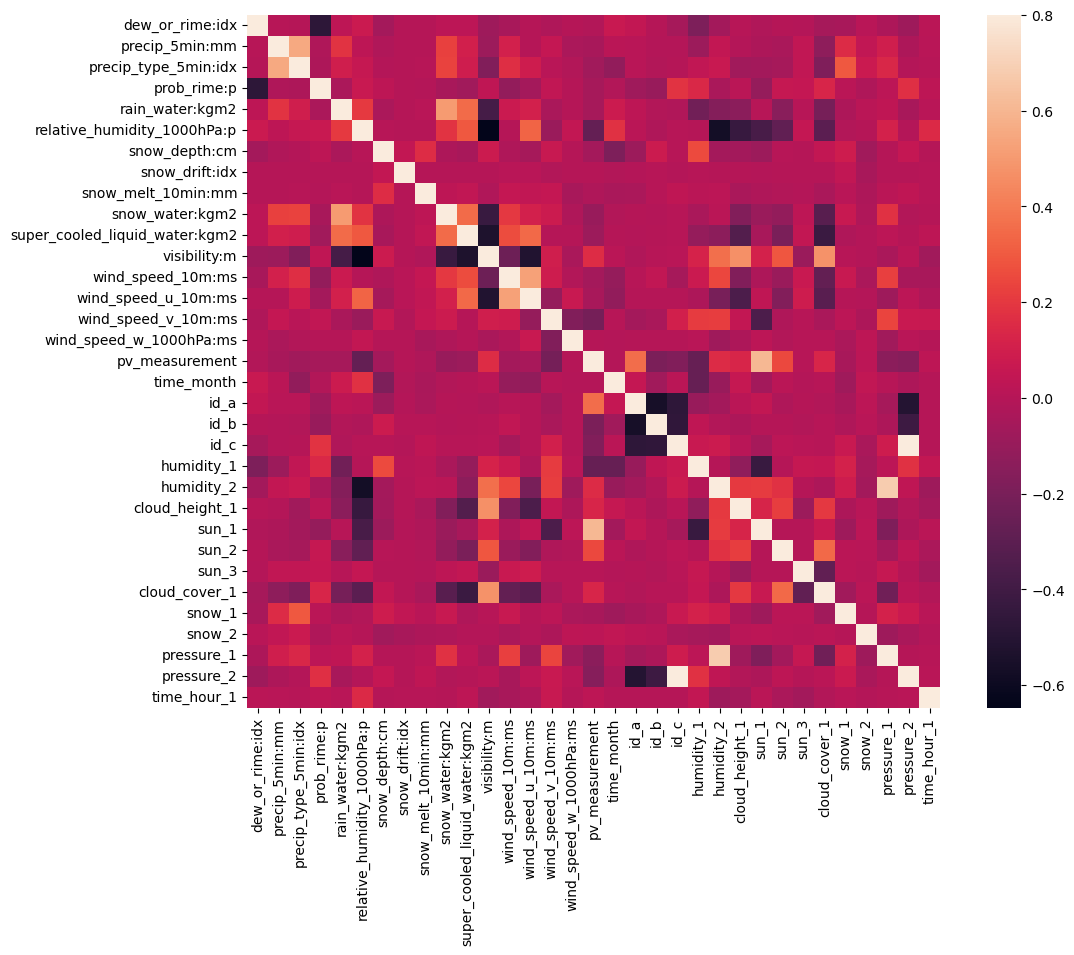

In [109]:
corrmat = data_train_o_pca.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

# Feature Importance

In [110]:
#data_train_o = data_train_o_pca.copy()
#random_forest = RandomForestRegressor(n_estimators=20, random_state=42)
#X = data_train_o.drop(columns=['pv_measurement'])
#y= data_train_o['pv_measurement']

#random_forest.fit(X, y)


In [111]:
"""
feature_importance_series = pd.Series(
    data=random_forest.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)

sns.barplot(
    x=feature_importance_series.index,
    y=feature_importance_series.values
)"""

'\nfeature_importance_series = pd.Series(\n    data=random_forest.feature_importances_,\n    index=X.columns\n).sort_values(ascending=False)\n\nplt.figure(figsize=(15,5))\nplt.xticks(rotation=90)\n\nsns.barplot(\n    x=feature_importance_series.index,\n    y=feature_importance_series.values\n)'

# Feature Selection

In [112]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression
data_train_o = data_train_o.sample(frac=1.0, random_state=42).reset_index(drop=True)


X = data_train_o.drop(columns=['pv_measurement'])
y = data_train_o['pv_measurement']
#Cross validation for k

#selector = SelectKBest(f_classif)
#parameters = {'kbest__k':list(range(5,49,10))}
#pipeline = Pipeline([('kbest', selector), ('lr', RandomForestRegressor())]) 
#cross = GridSearchCV(pipeline, parameters,verbose=10, n_jobs=-1, scoring='neg_mean_absolute_error').fit(X,y) #6 mins

In [113]:
#plt.figure()
#plt.plot(cross.cv_results_['mean_test_score'])

In [114]:
#cross.best_estimator_.get_params
# => taking top 7 features

In [115]:
#selector = SelectKBest(f_classif, k=10).fit(X, y)
#cols_idxs = selector.get_support(indices=True)
#cols_idxs
#X_new = X.iloc[:,cols_idxs] 

#X_new

In [116]:

#clf_rf_41 = xgboost.XGBRegressor()
#normal_data = RFECV(estimator=clf_rf_41, step=1, cv=4,scoring='neg_mean_absolute_error',n_jobs=-1, verbose=10)
#normal_data = normal_data.fit(X, y)

In [117]:
#print('Optimal number of features :', normal_data.n_features_)
#print('Best features :', X.columns[normal_data.support_])

#plt.figure(figsize=(16,9))
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score of number of selected features")
#plt.scatter(range(1, len(normal_data.cv_results_['mean_test_score']) + 1), normal_data.cv_results_['mean_test_score'])
#plt.show()

In [118]:
data_train_o_pca = data_train_o_pca.sample(frac=1.0, random_state=42).reset_index(drop=True)


X_pca = data_train_o_pca.drop(columns=['pv_measurement'])
y = data_train_o['pv_measurement']

#clf_rf_42 = xgboost.XGBRegressor()
#pca_data = RFECV(estimator=clf_rf_42, step=1, cv=4,scoring='neg_mean_absolute_error',n_jobs=-1, verbose=10)
#pca_data = pca_data.fit(X_pca, y)

In [119]:
#print('Optimal number of features :', pca_data.n_features_)
#print('Best features :', X_pca.columns[pca_data.support_])

#plt.figure(figsize=(16,9))
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score of number of selected features")
#plt.scatter(range(1, len(pca_data.cv_results_['mean_test_score']) + 1), pca_data.cv_results_['mean_test_score'])
#plt.show()


In [120]:

pca = RFE(estimator=xgboost.XGBRegressor(),n_features_to_select=9).fit(X_pca,y)
#corrmat = data_train_o_pca[X_pca.columns[pca.support_]].corr(numeric_only=True)
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True) Less correlated
X_pca.columns[pca.support_]


Index(['precip_5min:mm', 'precip_type_5min:idx', 'rain_water:kgm2', 'id_a',
       'sun_1', 'sun_2', 'cloud_cover_1', 'snow_1', 'time_hour_1'],
      dtype='object')

In [121]:
normal_data = RFE(estimator=xgboost.XGBRegressor(),n_features_to_select=8).fit(X,y)
#corrmat = data_train_o[X.columns[normal_data.support_]].corr(numeric_only=True)
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True)
X.columns[normal_data.support_]


Index(['diffuse_rad:W', 'direct_rad:W', 'is_in_shadow:idx', 'precip_5min:mm',
       'precip_type_5min:idx', 'sun_azimuth:d', 'sun_elevation:d', 'id_a'],
      dtype='object')

#